# Dataset Used:
[AlekseyKorshuk/romance-books](https://huggingface.co/datasets/AlekseyKorshuk/romance-books) from Hugging Face




- What is the right way of clustering?
- Is it based on the closeness or cosine similarity? What happens when we have more similar words, how can we cluster them?
- Can we have a new clustering technique, based on the next token?


In [3]:
import json

with open('romance_paragraphs_cleaned.json', 'r', encoding='utf-8') as f:
    paragraphs = json.load(f)

In [4]:
print(paragraphs[0])

I am exhausted, physically and mentally, by lunch time. Xavier has been dogged by so many people that even he is tired now, huffing beside me like a car that has just run out of gas. "This," he says, running a hair through his perfect, blue hair, "is why I haven't gone to school for the last thirty-two years." I blink, wondering if I had heard him right. "Thirty-two years?" I squeak, my voice barely above a whisper. Even now, as we casually walk down the hallway, people are staring at him, gossiping about the new senior that is sizzling hot. "Yeah. I was born fifty-five years ago, March 4, 1955, to be exact, and you are not eligible to go to school until you are five. So, that makes about thirty-two years since I last went. I only completed high school, and didn't go to college," he says plainly. My eyes widen with surprise as I absorb his words. "So you are fifty-five years old," I say dubiously. Somehow, that is hard to believe. He looks like a normal eighteen year old... an incredib

In [ ]:
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 \
  --index-url https://download.pytorch.org/whl/cu121

In [3]:
pip install xformers==0.0.28.post1 --no-dependencies

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 107.1 MB/s eta 0:00:00


#Model: OpenAI text-embedding-3-large

# Model: NovaSearch/stella_en_400M_v5

In [5]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("dunzhang/stella_en_400M_v5", trust_remote_code=True).cuda()
embeddings = model.encode(paragraphs)

Some weights of the model checkpoint at dunzhang/stella_en_400M_v5 were not used when initializing NewModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
pip install kneed

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from kneed import KneeLocator
from sklearn.decomposition import PCA

def find_knee_point_kmeans(
    embeddings,
    k_min=500,
    k_max=2000,
    k_step=100,
    pca_components=50,
    dtype=np.float32
):
    # Convert to numpy array and apply dtype
    embeddings = np.array(embeddings, dtype=dtype)

    # Dimensionality reduction
    pca = PCA(n_components=pca_components)
    embeddings_reduced = pca.fit_transform(embeddings)

    distortions = []
    K = list(range(k_min, k_max + 1, k_step))  # Sequential k values

    for k in K:
        kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=256)
        kmeans.fit(embeddings_reduced)
        distortions.append(kmeans.inertia_)

    # Find elbow point
    knee = KneeLocator(K, distortions, curve='convex', direction='decreasing')
    optimal_k = knee.knee

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(K, distortions, 'bo-', label='Inertia')
    if optimal_k:
        plt.axvline(optimal_k, color='red', linestyle='--', label=f'Knee at k={optimal_k}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Distortion)')
    plt.title('Elbow Method (Sequential k Values)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return optimal_k


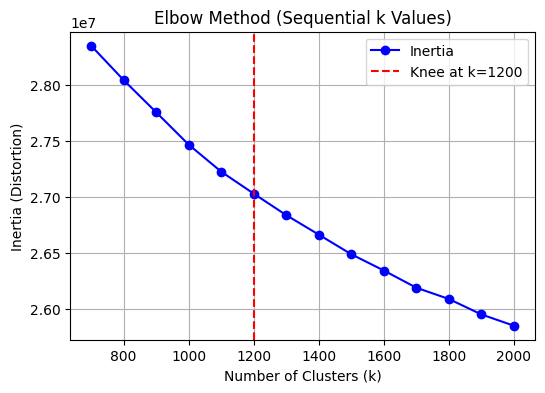

Best k: 1200


In [8]:
optimal_k = find_knee_point_kmeans(embeddings, k_min=700, k_max=2000, k_step=100)
print("Best k:", optimal_k)

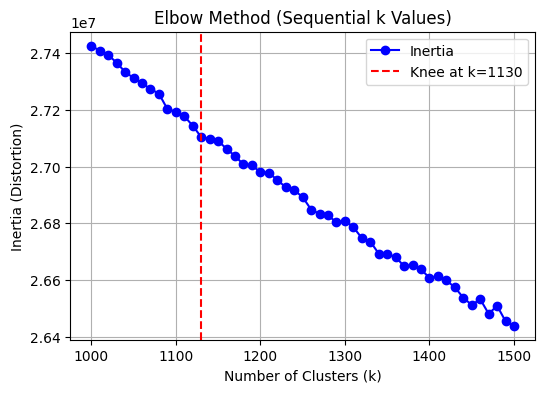

Best k: 1130


In [10]:
optimal_k = find_knee_point_kmeans(embeddings, k_min=1000, k_max=1500, k_step=10)
print("Best k:", optimal_k)

In [11]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(embeddings)

print(f"KMeans completed with k = {optimal_k}")

KMeans completed with k = 1130


In [12]:
#find the number of points in each clusters. store it into a vector.
from collections import Counter

cluster_counts = Counter(labels)

counts = np.array(list(cluster_counts.values()))


sorted_counts_desc = np.sort(counts)[::-1]

print("sentence counts sorted: ", sorted_counts_desc)

sentence counts sorted:  [1452 1221 1208 ...   76   68   51]


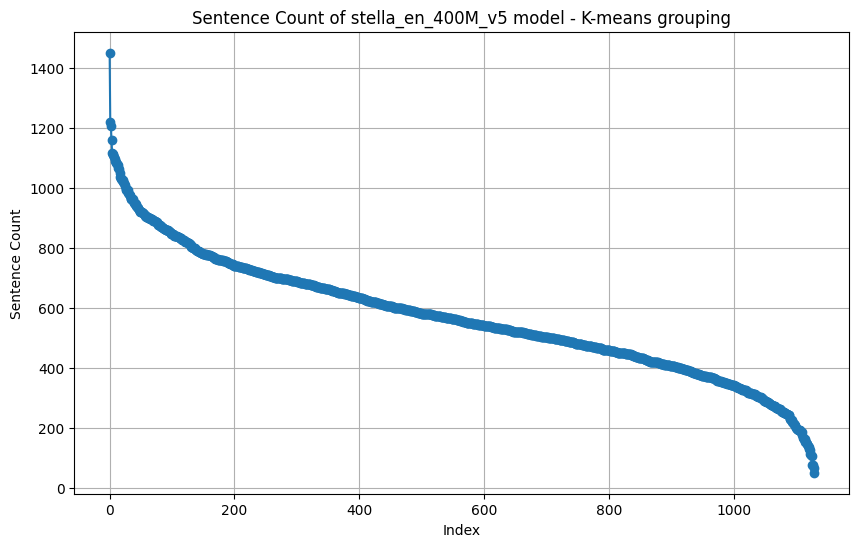

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Plot sentence count distribution
plt.figure(figsize=(10, 6))
plt.plot(range(len(sorted_counts_desc)), sorted_counts_desc, marker='o')
plt.title("Sentence Count of stella_en_400M_v5 model - K-means grouping")
plt.xlabel('Index')
plt.ylabel('Sentence Count')
plt.grid(True)
plt.show()


Regression Results:
   - Slope: -0.3223
   - Intercept: 3.5702
   - R-squared: 0.6336
   - P-value: 3.2996e-248


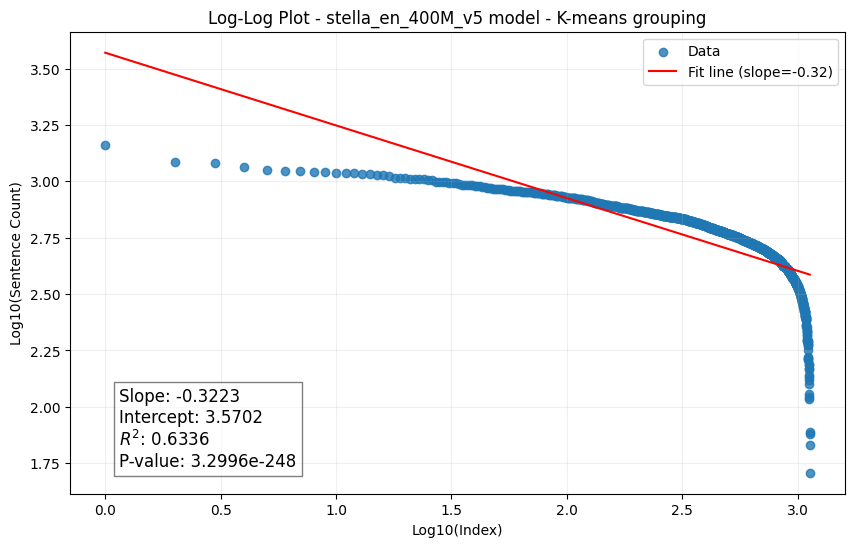

In [13]:
from scipy.stats import linregress

# linear regression function
def linear_regression(counts):
    x = np.log10(np.arange(1, len(counts)+1))
    y = np.log10(counts)
    slope, intercept, r_val, p_val, std_err = linregress(x, y)
    y_pred = slope * x + intercept
    return x, y, slope, intercept, r_val, p_val, y_pred

# apply regression
x, y, slope, intercept, r_val, p_val, y_pred = linear_regression(sorted_counts_desc)

# plot regression line on log-log data
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.8, label='Data')
plt.plot(x, y_pred, 'r-', label=f'Fit line (slope={slope:.2f})')
plt.title("Log-Log Plot - stella_en_400M_v5 model - K-means grouping")
plt.xlabel('Log10(Index)')
plt.ylabel('Log10(Sentence Count)')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

# annotate stats
text_x = min(x) + (max(x) - min(x)) * 0.02
text_y = min(y) + (max(y) - min(y)) * 0.02
plt.text(text_x, text_y,
         f"Slope: {slope:.4f}\nIntercept: {intercept:.4f}\n$R^2$: {r_val**2:.4f}\nP-value: {p_val:.4e}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

print("\nRegression Results:")
print(f"   - Slope: {slope:.4f}")
print(f"   - Intercept: {intercept:.4f}")
print(f"   - R-squared: {r_val**2:.4f}")
print(f"   - P-value: {p_val:.4e}")

plt.show()